**Group Project Assignment - Analysis of Customer Data (Spring)**

 My contribution is data distribution by timestamp in Part 1, matrix factorization-based method and model comparison in Part 2.

## **Assignment Setup**

This section sets up the environment by importing all necessary libraries and packages:
- Pandas and numpy for data manipulation
- Seaborn for data visualization
- Surprise for recommender system implementation

In [ ]:
!pip install scikit-surprise

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns

sns.set()
sns.set_style('whitegrid')
sns.set_context('paper', font_scale=1.6, rc={"lines.linewidth": 2})
import matplotlib.pyplot as plt

from surprise import Dataset
from surprise import Reader
from surprise import NormalPredictor
from surprise.model_selection import cross_validate
from surprise.model_selection import KFold
from datetime import datetime
import time
from surprise import KNNWithZScore
from surprise.model_selection import GridSearchCV
from surprise import SVD

# **Part 1: Preparing and Understanding the Dataset**


## 1.1 Data loading

In this section, we load the data from the CSV file and display basic statistics to check if the data has been successfully loaded and to help understand the dataset.

In [ ]:
ratings = pd.read_csv('MovieLens-Ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,307,3.5,1256677221
1,1,481,3.5,1256677456
2,1,1091,1.5,1256677471
3,1,1257,4.5,1256677460
4,1,1449,4.5,1256677264


The following code calculates key statistics to help us better understand the dataset in preparation for the next data filtering. We use the nunique() function to determine the number of unique users and the number of unique movies. The len() function is used to check the total number of ratings in the dataset.
The dataset contains a total of 283,228 unique users, 53,889 unique movies, and 27,753,444 ratings. Finally, note that the column names are used to directly access and analyze the relevant features in the DataFrame.

In [ ]:
unique_users = ratings['userId'].nunique()
unique_movies = ratings['movieId'].nunique()

print(f"""
Dataset Statistics:
- Unique users: {unique_users:,}
- Unique movies: {unique_movies:,}
- Total ratings: {len(ratings):,}
""")


Dataset Statistics:
- Unique users: 283,228
- Unique movies: 53,889
- Total ratings: 27,753,444



## 1.2 Data exploration and analysis

**Rating distribution**

Users may have certain preferences when rating. Users may tend to watch and leave ratings for movies that they are interested in. Therefore, this code counts and visualizes the frequency of each score value in the rating column. Use value_counts() to get the number of ratings corresponding to each rating value, and then use sort_index() to ensure that the ratings are sorted from low to high.

From the generated bar chart, the rating distribution is not uniform, but clearly skewed towards high scores: movies with a rating of 4.0 are the most, with nearly 7.5 million ratings. This distribution pattern is a typical positively skewed distribution (users tend to give high scores), which is very common in recommendation systems and also indicates that the data is non-uniform and non-normally distributed.

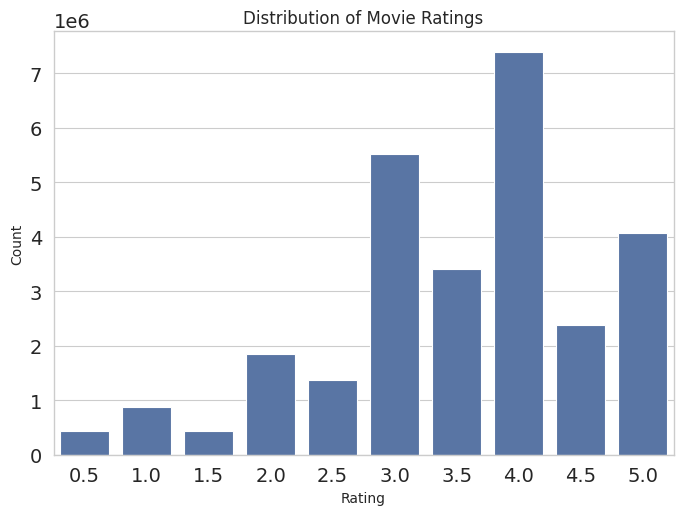

In [ ]:
def plot_rating_distribution(data):
    plt.figure(figsize=(8, 5.5))
    rating_counts = data['rating'].value_counts().sort_index()
    sns.barplot(x=rating_counts.index, y=rating_counts.values)
    plt.title('Distribution of Movie Ratings', fontsize=12)
    plt.xlabel('Rating', fontsize=10)
    plt.ylabel('Count', fontsize=10)
    plt.show()

plot_rating_distribution(ratings)

**The distribution of ratings over the years**

The user preferences for movies might change over time, as new productions are released each year. Time relevance is important if we need to build an up-to-date recommendation system. Meanwhile, time is also implicit information that can be modeled into the recommender system, such as in timeSVD++. Therefore, it might be helpful to examine the time span of the dataset and the distribution of ratings over time. From the data, the ratings start from early 1995 till 2018, covering a long period of over two decades. The distribution of the ratings shows notable peaks around 1997, 2000, and 2016, with a significant decrease between 1998 and 2000. The distribution stabilized from 2002 to 2014. Following the peak around 2016, the users remained active in the subsequent years.



In [ ]:
# convert timestamp to datetime
ratings['date'] = ratings['timestamp'].apply(datetime.fromtimestamp)
ratings.head()

,userId,movieId,rating,timestamp,date
0,1,307,3.5,1256677221,2009-10-27 21:00:21
1,1,481,3.5,1256677456,2009-10-27 21:04:16
2,1,1091,1.5,1256677471,2009-10-27 21:04:31
3,1,1257,4.5,1256677460,2009-10-27 21:04:20
4,1,1449,4.5,1256677264,2009-10-27 21:01:04


In [ ]:
# get the earliest and the latest ratings
earliest = np.min(ratings['date']).date()
latest = np.max(ratings['date']).date()
print('The ratings cover a period from {} to {}.'.format(earliest, latest))

The ratings cover a period from 1995-01-09 to 2018-09-26.


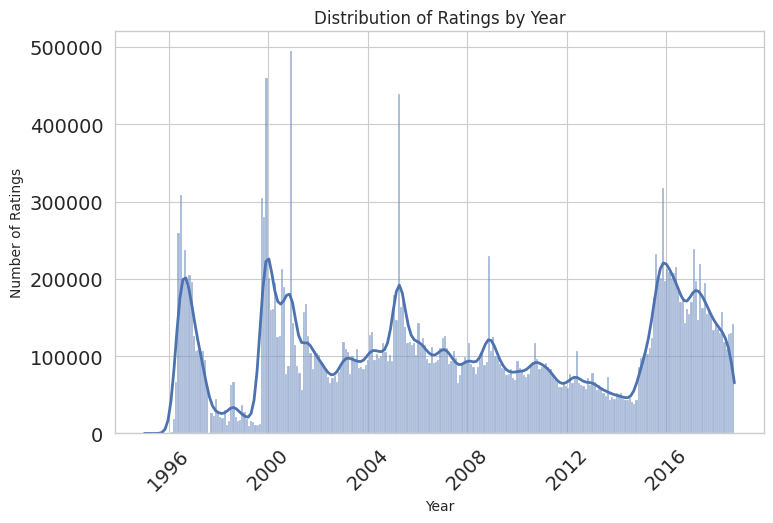

In [ ]:
# plot the distribution of ratings over the years
plt.figure(figsize=(8,5.5))
sns.histplot(ratings['date'], kde=True)
plt.title('Distribution of Ratings by Year', fontsize=12)
plt.xlabel('Year', fontsize=10)
plt.ylabel('Number of Ratings', fontsize=10)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**User rating activity**

Most users are likely to contribute only a few ratings. Users with few ratings may lack personalized information, while a small number of highly active users dominate the dataset. By counting the number of ratings for each user, a distribution histogram of the number of ratings is plotted using logarithmic coordinates. There are obvious spikes in the number of ratings, which may be due to the rating tasks set by the platform (such as "rating 10 times to unlock features"). This skewed activity distribution brings challenges such as data sparsity and cold start problems.


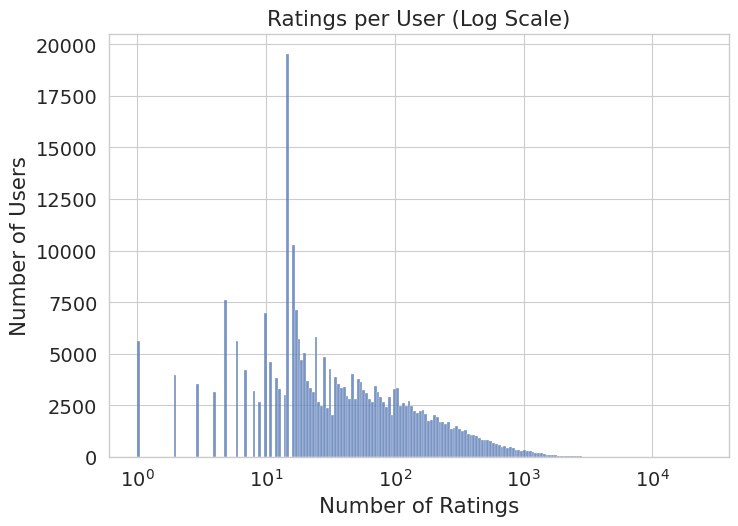

In [ ]:
def plot_user_rating_activity(data):
    user_counts = data['userId'].value_counts()
    plt.figure(figsize=(8, 5.5))
    sns.histplot(user_counts, bins=200, log_scale=True)
    plt.title('Ratings per User (Log Scale)')
    plt.xlabel('Number of Ratings')
    plt.ylabel('Number of Users')
    plt.show()

plot_user_rating_activity(ratings)

**The density distribution of movie ratings**

The number of ratings received by each movie may be uneven, with a small number of movies being frequently rated and most movies being almost unrated. The KDE histogram of movieId shows that the distribution of movie popularity is highly skewed and sparse. A small number of movies (usually those with lower IDs) receive a large number of ratings, which may reflect their mainstream or popular status. In contrast, the vast majority of movies are rated very infrequently. The common long-tail phenomenon is present in the dataset.

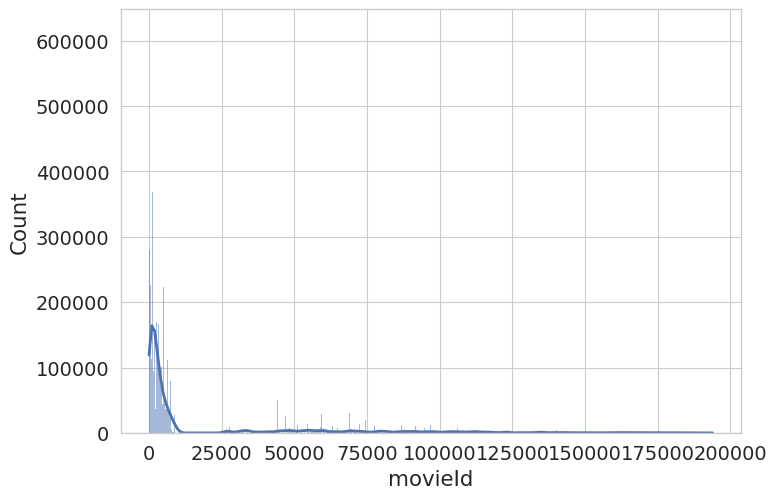

In [ ]:
def plot_density(data):
    fig, ax = plt.subplots(figsize=(8,5.5))
    plot = sns.histplot(data['movieId'], kde=True, ax=ax)

plot_density(ratings)

**Explanation on the following plots:**  

Plot 1: After filtering, most users are still concentrated in a small number of ratings (< 100), but the tail users are retained, indicating a reasonable distribution.

Plot 2: The long-tail phenomenon is obvious, which is in line with the law of ‘a few films are widely rated’ in real data. The middle density is retained after filtering, which is a good dataset for model building.

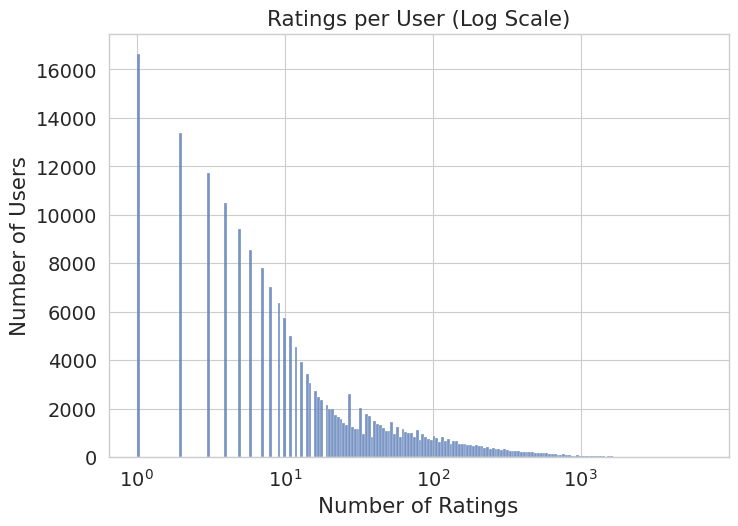

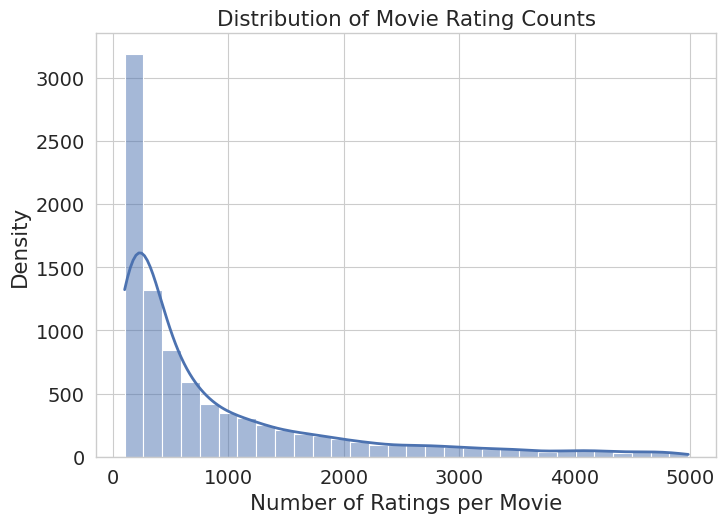

In [ ]:
# Defining Plotting Functions
def plot_user_rating_activity(data):
    user_counts = data['userId'].value_counts()
    plt.figure(figsize=(8, 5.5))
    sns.histplot(user_counts, bins=200, log_scale=True)
    plt.title('Ratings per User (Log Scale)')
    plt.xlabel('Number of Ratings')
    plt.ylabel('Number of Users')
    plt.show()

def plot_rating_density(data):
    rating_counts = data['movieId'].value_counts()
    fig, ax = plt.subplots(figsize=(8, 5.5))
    sns.histplot(x=rating_counts.values, kde=True, bins=30, ax=ax)
    ax.set_title('Distribution of Movie Rating Counts')
    ax.set_xlabel('Number of Ratings per Movie')
    ax.set_ylabel('Density')
    plt.show()

# user filters: number of ratings ≥10, eliminate users who have barely engaged with ratings to avoid too much noise
user_counts = ratings['userId'].value_counts()
valid_users = user_counts[user_counts >= 10].index
filtered_ratings = ratings[ratings['userId'].isin(valid_users)]

# movie filters: reviews between 100 and 5000 times, excluding extremely cold movies (ratings < 100) to prevent sparsity from affecting similarity calculation later and excluding extremely popular movies (number of ratings > 5000) to avoidpopular movies from dominating the recommendations and improving diversity
movie_counts = filtered_ratings['movieId'].value_counts()
valid_movies = movie_counts[(movie_counts >= 100) & (movie_counts <= 5000)].index
final_ratings = filtered_ratings[filtered_ratings['movieId'].isin(valid_movies)]

# generate EDA charts
plot_user_rating_activity(final_ratings)
plot_rating_density(final_ratings)

## 1.3 Preparing the data
Preparing the data to run the algorithms.

**Stratified sampling by users: 10% randomly selected from all users. The reasons are as follows:**
1. Reduce data size by sampling to avoid excessive computational cost, facilitating debugging and rapid model validation later.
2. Preserve the user behavior structure, thus preventing distortion caused by random sampling.

In [ ]:
# Stratified sampling by users: 10% randomly selected from all users.
unique_users = final_ratings['userId'].unique()
sampled_users = pd.Series(unique_users).sample(frac=0.1, random_state=42)

# Filter all rating records for these users; the structure of the rating distribution is preserved.
sampled_ratings = final_ratings[final_ratings['userId'].isin(sampled_users)]

In [ ]:
# print sampled statistics
print("Sampled ratings:", sampled_ratings.shape[0])
print("Sampled users:", sampled_ratings['userId'].nunique())
print("Sample movies:", sampled_ratings['movieId'].nunique())

Sampled ratings: 826369
Sampled users: 19228
Sample movies: 9146


In [ ]:
# Preparing the data based on the range of ratings
min_rating = sampled_ratings['rating'].min()
max_rating = sampled_ratings['rating'].max()
reader = Reader(rating_scale=(min_rating, max_rating))

data = Dataset.load_from_df(sampled_ratings[['userId', 'movieId', 'rating']], reader)

# k-fold cross-validation
cv = KFold(n_splits=5, random_state=42, shuffle=True)

## 1.4 NormalPredictor method - baseline

We use the NormalPredictor as the baseline, and to compare and assess the performance of selected algorithms.

In [ ]:
# Baseline: NormalPredictor
algo_baseline = NormalPredictor()
results_baseline = cross_validate(algo_baseline, data, measures=['RMSE'], cv=cv, verbose=True)

Evaluating RMSE of algorithm NormalPredictor on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.5007  1.4991  1.4999  1.4962  1.5033  1.4998  0.0023  
Fit time          0.74    0.92    0.94    0.90    0.93    0.89    0.08    
Test time         1.02    1.23    1.01    0.98    1.06    1.06    0.09    


In [ ]:
print("Baseline: NormalPredictor")
print("Average RMSE:", round(results_baseline['test_rmse'].mean(), 4))

Baseline: NormalPredictor
Average RMSE: 1.5007


# **Part 2: Describing, Configuring and Comparing the Selected Algorithms against the Baseline**

# 2.1 Neighborhood method - KNNWithZScore

KNNWithZScore algorithm belongs to the neighborhood-based methods family.
It uses the Z-score normalization to adjust each rating based on the mean and standard deviation of the corresponding user or item, thereby correcting for individual rating tendencies.</span>

<ul>
  <li>It computes similarity metrics between users or items.</li>
  <li>It finds the k most similar users (neighbors) to the target user.</li>
  <li>It adjusts ratings by accounting for each user's mean and standard deviation to eliminate differences in rating scales between users.</li>
</ul>

In [ ]:
# Configuration 1: user-based, cosine similarity, k=3

sim_options_1 = {
    'name': 'cosine',
    'user_based': True
}
algo1 = KNNWithZScore(k=3, sim_options=sim_options_1)
results1 = cross_validate(algo1, data, measures=['RMSE'], cv=cv, verbose=True)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNWithZScore on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.0257  1.0260  1.0269  1.0212  1.0273  1.0254  0.0022  
Fit time          26.34   26.79   27.06   26.96   26.78   26.79   0.25    
Test time         22.06   22.30   21.87   21.35   22.28   21.97   0.35    


In [ ]:
print("Configuration 1: User-based, Cosine, k=3")
print("Average RMSE:", round(results1['test_rmse'].mean(), 4))

Configuration 1: User-based, Cosine, k=3
Average RMSE: 1.0254




    
**Explanation on Configuration 1 results:**  
k=3 is a small neighbourhood size, focusing on the top 3 most similar users, enabling highly personalized predictions.
The RMSE is lower than the baseline, which indicates better performance than NormalPredictor.


In [ ]:
# Configuration 2: item-based, pearson similarity，k=10

sim_options_2 = {
    'name': 'pearson',
    'user_based': False
}
algo2 = KNNWithZScore(k=10, sim_options=sim_options_2)
results2 = cross_validate(algo2, data, measures=['RMSE'], cv=cv, verbose=True)

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNWithZScore on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9082  0.9100  0.9095  0.9077  0.9083  0.9087  0.0009  
Fit time          23.80   23.85   24.38   23.93   24.52   24.10   0.29    
Test time         33.58   32.90   33.97   33.41   33.91   33.55   0.39    


In [ ]:
print("Configuration 2: Item-based, Pearson, k=10")
print("Average RMSE:", round(results2['test_rmse'].mean(), 4))

Configuration 2: Item-based, Pearson, k=10
Average RMSE: 0.9087




**Explanation on Configuration 2 results:**  
It considers linear relationships between rating vectors.  Item-based similarity tends to be more stable than user-based similarity, especially in large datasets.  
Increasing the number of neighbors to 10 further stabilizes predictions. The significantly lower RMSE demonstrates better generalization and predictive performance than the user-based configuration.


In [ ]:
# Grid Search: testing different combinations of configurations

# Define hyperparameter Grid
param_grid = {
    'k': [3, 5, 10],
    'sim_options': {
        'name': ['cosine', 'pearson'],
        'user_based': [True, False]
    }
}

# Use GridSearchCV to test all combinations using 5-fold cross-validation and evaluate with RMSE
gs = GridSearchCV(KNNWithZScore, param_grid, measures=['rmse'], cv=cv)

# Implement Grid Search
gs.fit(data)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing

In [ ]:
# Output the best-performing model
print("Best RMSE score:", gs.best_score['rmse'])
print("Best parameters:", gs.best_params['rmse'])

Best RMSE score: 0.9087448981409627
Best parameters: {'k': 10, 'sim_options': {'name': 'pearson', 'user_based': False}}


In [ ]:
# Re-train and re-evaluate the best model found by grid search
best_algo = gs.best_estimator['rmse']
results_KNN = cross_validate(best_algo, data, measures=['RMSE'], cv=cv, verbose=True)

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNWithZScore on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9082  0.9100  0.9095  0.9077  0.9083  0.9087  0.0009  
Fit time          24.52   24.49   24.78   24.58   24.91   24.65   0.16    
Test time         33.28   33.66   32.82   33.15   33.53   33.29   0.29    


In [ ]:
# Print final results
print("Best configuration found by Grid Search:")
print("Similarity:", gs.best_params['rmse']['sim_options']['name'])
print("User-based:", gs.best_params['rmse']['sim_options']['user_based'])
print("k:", gs.best_params['rmse']['k'])
print("Average RMSE:", round(results_KNN['test_rmse'].mean(), 4))

Best configuration found by Grid Search:
Similarity: pearson
User-based: False
k: 10
Average RMSE: 0.9087



**Explanation on Grid Search results:**  
It optimizes the KNNWithZScore recommendation algorithm with hyperparameters using a grid search approach.
The best configuration is found by considering the similarity relationship between items, using the Pearson correlation coefficient and a larger number of neighbors (10).




**Overall Model Explanation:**  
Overall, KNNWithZscore improves the comparability of ratings among users/items compared with the normal predictor. As for RMSE, the item-based Pearson similarity configuration is superior to the user-based configuration,
which indicates the relationships between items are of more reference value for recommendations for this dataset. The results also show that parameter adjustment will significantly affect the recommendation quality.


# 2.2 Matrix Factorization-based Method

Different from the neighbourhood approach, which uses similarities between items or users, matrix factorisation-based methods utilise information from both sides. They put users and items into a shared latent factor space to capture interactions. As a model-based method, matrix factorisation approaches recommendation as a prediction problem, learning patterns from the latent space to estimate unknown ratings. The model chosen in this project is Singular Value Decomposition (SVD). It represents the data in a matrix where users are rows and items are columns. Since most users rate only a small portions of the entire item repository, this matrix is sparse. The missing values are what the model will be predicting as recommendations.

The prediction task is formulated as a loss minimisation problem, which occurs in two stages. First, baseline predictions are computed using user and item deviations from their respective averages, without modeling their interactions. Second, user-item interactions are modeled by factorising the rating matrix into two latent feature matrices. One representing item characteristics, and the other representing the extent of interest users have in those features. The dot product of these two matrices adds user-item interactions into the model. Through Stochastic Gradient Descent (SGD) or Alternating Least Squares (ALS), optimal deviations and latent factors will be learned by minimising the errors between the predicted and actual ratings.

The hyperparameters to be optimised in our model are the number of factors, regularisation rate and learning rate. These hyperparameters are explained below:

*   number of factors: It defines the number of latent factors to represent users and items. Higher values allow the matrices to capture more nuanced interactions, thus increasing the model complexity.  
*   regularisation rate: Due to the sparsity of the matrix, the model is prone to overfitting. Regularisation helps to avoid overfitting by penalising large parameter values. The larger the regularisation rate, the heavier the penalisation. In SVD, regularisation is applied to user and item deviations, the overall deviation, and the two latent factor matrices.
*   learning rate: It controls the speed of the gradient descent. A higher learning rate leads to faster convergence but risks overshooting the optimal point. Similar to the regularisation rate, different learning rates are also applied to each parameter in the model. Due to computational constraints, these two rates will be tuned globally for all the parameter.

In [ ]:
# hyperparameter tuning
param_grid_SDV = {'n_factors': [95, 100, 110],
                  'lr_all': [0.018, 0.02, 0.022],
                  'reg_all': [0.07, 0.08, 0.09]
                  }
grid_search_SDV = GridSearchCV(SVD,
                               param_grid_SDV,
                               measures=['rmse'],
                               cv=cv)
grid_search_SDV.fit(data)

In [ ]:
# get the score and parameters for the best configuration
print(grid_search_SDV.best_score['rmse'])
print(grid_search_SDV.best_params)

0.8377733916626768
{'rmse': {'n_factors': 100, 'lr_all': 0.02, 'reg_all': 0.08}}


In [ ]:
# cross validation
SDV_means_best = grid_search_SDV.best_estimator['rmse']
results_SDV = cross_validate(SDV_means_best, data, cv=cv, return_train_measures=True, verbose=True)
print('The avereage RMSE of tuned SDV is:', np.mean(results_SDV['test_rmse']))

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8379  0.8399  0.8395  0.8369  0.8367  0.8382  0.0013  
MAE (testset)     0.6377  0.6394  0.6400  0.6383  0.6379  0.6386  0.0009  
RMSE (trainset)   0.6007  0.6011  0.6013  0.6010  0.6018  0.6012  0.0004  
MAE (trainset)    0.4644  0.4647  0.4648  0.4646  0.4652  0.4647  0.0003  
Fit time          10.45   10.75   10.80   10.80   10.75   10.71   0.13    
Test time         1.28    1.80    1.71    1.71    1.67    1.63    0.18    
The avereage RMSE of tuned SDV is: 0.8382036814204795


To optimise the performance of the SVD model, several rounds of hyperparameters tuning were conducted. The process began with a broad grid centered around the default values. The initial results showed that moderate model complexity, with n_factors between 80 and 100, performed best. This range allowed the model to learn meaningful patterns while avoid overfitting.

Throughout the process, higher learning rates and stronger regularisations were consistently preferred, confirming that the model was prone to overfitting. By pushing the two values to the higher end, they finalised respectively at 0.02 and 0.08, beyond which no further improvement was observed. This configuration achieved a balance between model complexity and generalisation.

Comparing the model evaluation with the grid search result, the closeness of the two RMSE scores suggests that the model generalised well and was not showing evident signs of overfitting. The average difference between the predictions and the actual ratings (RMSE) on the test set is 0.8382 with a small standard deviation of 0.0013, indicating stable performance across folds.

# 2.3 Model Comparison

In our comparison, NormalPredictor, as the baseline, performed the worst with an RMSE of 1.4998. KNNWithZScore came second with an RMSE of 0.9087, while SVD achieved the best performance with an average RMSE of 0.8397. Model-based method outperformed both the neighbourhood-based method and the baseline.

The baseline model has the simpliest model structure. It predicts ratings by randomly drawing values from a normal distribution that matches the mean and standard deviation of the known ratings. It does not take user preferences or item characteristics into account, which explains the poor predictive performance.

The better score of SVD compared to KNNWithZScore might be due to the fact that the latent factors in the matrix factorisation-based models can capture more various aspects of information. These factors encode broader range of item characteristics beyond direct similarity calculations. In particular, SVD models user-item interactions, rather than considering users and items separately. Furthermore, KNNWithZscore is a more localised method. It relies on the relationship amongst the nearest neighbours, while SDV can take a global view of the overall relationships using the matrices. This access to global patterns might contribute to better prediction result.

In [ ]:
# compare the best result from each model
results = [('NormalPredictor', round(np.mean(results_baseline['test_rmse']), 4)),
           ('KNNWithZscore', round(np.mean(results_KNN['test_rmse']), 4)),
           ('SDV', round(np.mean(results_SDV['test_rmse']), 4))]
results_sorted = sorted(results, key=lambda x: x[1], reverse=False)
for i in range(len(results_sorted)):
  print('The No.{} average RMSE result is {} with the score of {}'.format(i+1, results_sorted[i][0], results_sorted[i][1]))

The No.1 average RMSE result is SDV with the score of 0.8378
The No.2 average RMSE result is KNNWithZscore with the score of 0.9087
The No.3 average RMSE result is NormalPredictor with the score of 1.4998
